# Import Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import FunctionTransformer

### Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB 

from sklearn.metrics import confusion_matrix,auc,roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

import collections

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=FitFailedWarning)

# Helper Functions

In [3]:
def get_data_by_class(data):
    fraud = data[data.Class==1]
    not_fraud = data[data.Class==0]

    return fraud, not_fraud

In [4]:
def eliminate_extreme_amount(data, col='Amount', threshold=3000):
    new_data = data[(data[col] <= threshold)].copy()

    return new_data

In [5]:
def stratified_train_test_byclass(data, feature_names, by, test_size=0.3):
    ## convert seconds to hour, assign this info to a new column
    to_hour = np.floor(data.Time/(60*60)).astype(int)
    for t in range(len(to_hour)):
        if to_hour[t] >= 24:
            to_hour[t] = to_hour[t] - 24

    data['TimeHour'] = to_hour

    X = data.drop('Class', axis=1).copy()
    y = data[class_name]

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size, random_state=1, stratify=data[by])

    X_train.drop('TimeHour', axis=1, inplace=True)
    X_test.drop('TimeHour', axis=1, inplace=True)

    return X_train, X_test, y_train, y_test

In [6]:
import matplotlib.gridspec as gridspec

def draw_density_curve(data):
    frauds = data.Class == 1
    normals = data.Class == 0

    grid = gridspec.GridSpec(10, 3)
    plt.figure(figsize=(15,30))

    for i, col in enumerate(data[feature_names[1:-1]]): #exclude Time and Amount
        ax = plt.subplot(grid[i])
        sns.distplot(data[col][frauds], bins = 50, color='g')
        sns.distplot(data[col][normals], bins = 50, color='r')
        ax.set_ylabel('Density')
        ax.set_title(str(col))
        ax.set_xlabel('')
    plt.show()

In [7]:
def draw_boxplot(data, feature_names, img_size=(15,15)):
    fig, axes = plt.subplots(nrows=4, ncols=6,figsize=img_size)
    count_row = 0
    count_col = 0

    for i in range(len(feature_names)):
        sns.boxplot(ax=axes[count_row, count_col], data=data,
                    x='Class', y=feature_names[i], palette='Spectral')
        if count_col == 5:
            count_col = 0
            count_row += 1
        else:
            count_col += 1

    plt.tight_layout()
    plt.show()

In [8]:
def model_eval_recall(model, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)

    return np.mean(scores)

def confusion_mtx(y_true, y_pred, title=""):
    cf_mtx = confusion_matrix(y_true, y_pred)
    print(cf_mtx)
    print(classification_report(y_true,y_pred))

In [9]:
def log_transform(data):
    epsilon = 0.001
    data.Amount = np.log(data.Amount + epsilon)

    return data

log_transform = FunctionTransformer(log_transform)

In [10]:
def get_predictions(clf, X_train, y_train, X_test): 
    '''
    train model according to the specified classifier
    
    input: 
        clf: classifier (as imported from sklearn module)
        X_train: training observations 
        y_train: label for training observations 
        X_test: test observations 
    output: 
        y_predict: predicted label for the test observations 
        y_predict_proba: predicted class probability for the test observations
    '''
    # create classifier
    clf = clf 
    # fit classifier to training data 
    clf.fit(X_train, y_train)
    # predict on test data 
    y_predict = clf.predict(X_test)
    # compute predicted probability 
    y_predict_proba = clf.predict_proba(X_test)
    return y_predict, y_predict_proba

In [11]:
def print_scores(y_test, y_predict, y_predict_proba):
    '''
    print the scores
    '''
    print("test set confusion matrix:\n", confusion_matrix(y_test, y_predict))
    print("recall score: ", recall_score(y_test, y_predict))
    print("precision score: ", precision_score(y_test,y_predict))
    print("accuracy score: ", accuracy_score(y_test, y_predict))
    print("f1 score: ", f1_score(y_test,y_predict))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_predict_proba[:,1])))

    return precision_score(y_test,y_predict), recall_score(y_test, y_predict)

**Comment 1:** Eliminate features that show the (approx) same density curve between `Fraud` and `Not Fraud`: V15, V20, V22, V24, V25, V26, V28.

**Comment 2:** Most of the remaining features expect for Time, Amount, and V1 of the class `Not Fraud` (red color) are approximately formed as Normal Distribution. As we have a lots of data for this class, we may want to drop some **extreme outliers** so that our data satisfies the assumptions of learning models such as Logistic Regression.

In [12]:
def drop_feature(data, remove=['V13', 'V15', 'V22', 'V24', 'V25', 'V26', 'Time']):
    return data.drop(remove, axis=1)

drop_feature = FunctionTransformer(drop_feature)

In [13]:
def outlier_removal(data):
    fraud, not_fraud = get_data_by_class(data)
    feature_names = data.columns

    Q1 = not_fraud[np.setdiff1d(feature_names, ['Amount', 'V1'])].quantile(0.25)
    Q3 = not_fraud[np.setdiff1d(feature_names, ['Amount', 'V1'])].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 2.5 * IQR
    higher_whisker = Q3 + 2.5 * IQR

    extreme = not_fraud[((not_fraud < lower_whisker) |(not_fraud > higher_whisker)).any(axis=1)]
    not_fraud = not_fraud[~((not_fraud < lower_whisker) |(not_fraud > higher_whisker)).any(axis=1)]

    data = pd.concat([fraud, not_fraud]).reset_index(drop=True)

    return data, extreme

In [14]:
def robust_scaler(X_train_transform, X_test_transform):
    scaler = RobustScaler()
    features = X_train_transform.columns

    X_train_transform = scaler.fit_transform(X_train_transform)
    X_test_transform = scaler.fit_transform(X_test_transform)

    X_train_transform = pd.DataFrame(X_train_transform, columns=features)
    X_test_transform = pd.DataFrame(X_test_transform, columns=features)

    return X_train_transform, X_test_transform

# Preprocessing data

## Load data

In [15]:
# pj_path = os.getcwd() ## get current path
# data_path = os.path.join(pj_path, 'creditcard.csv')
data_path = '/home/phuong/Downloads/stats learning/project data science/creditcard.csv'
raw = pd.read_csv(data_path) # load data from the given csv file

## get feature and class names
all_cols = raw.columns
feature_names = raw.columns[:-1]
class_name = raw.columns[-1]

print(raw.shape)
raw.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Splitting raw data 

In [16]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = \
    stratified_train_test_byclass(raw, feature_names, [class_name, 'TimeHour'])


### Transform raw data

In [17]:
from copy import deepcopy

transformer = Pipeline([('logAmount', log_transform),
                        ('dropFeatures', drop_feature)])

X_train_raw_transform = transformer.fit_transform(deepcopy(X_train_raw))
X_test_raw_transform = transformer.transform(deepcopy(X_test_raw))

In [18]:
X_train_raw_transform, X_test_raw_transform = robust_scaler(X_train_raw_transform, X_test_raw_transform)
X_train_raw_transform.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V16,V17,V18,V19,V20,V21,V23,V27,V28,Amount
0,-0.315744,-0.022560,0.781190,0.316693,0.029852,0.044179,0.340706,-0.239550,0.214786,-0.827989,...,0.348428,0.722665,0.794576,0.428187,1.786105,0.281148,0.618446,-0.300491,-0.302631,0.677131
1,0.925438,0.029940,-1.020945,0.254271,0.373978,-0.455245,0.087605,-0.395965,0.525706,-0.269549,...,0.327908,0.582459,-0.175757,0.122565,-0.373306,-0.851116,1.097206,-0.421438,-0.339957,-0.923106
2,-1.298557,-0.463563,-0.113693,1.095429,-0.775344,0.796296,0.988980,0.618315,-0.077789,0.416724,...,-0.670524,0.639812,-0.128875,1.056363,-0.761454,-0.550586,-2.955878,7.777107,-3.755432,1.145135
3,0.525225,0.242929,0.137721,0.455537,-0.137251,-0.414776,0.053385,-0.334183,-0.105175,-0.274301,...,-0.035093,0.432304,-1.005410,-0.753789,0.057693,-0.470065,0.632124,0.005647,0.170056,-0.961741
4,-0.252712,-0.276477,-0.348813,-1.492189,0.326320,-0.347007,0.698994,-0.569688,-0.621672,0.374185,...,1.365126,-0.507564,-0.816685,-0.014495,0.263432,1.161720,-0.911299,2.220866,1.635673,0.715806


In [19]:
X_test_final = X_test_raw_transform
y_test_final = y_test_raw

In [20]:
print("Number of fraud transactions in test set: ", sum(y_test_final))

Number of fraud transactions in test set:  149


## Splitting cleaned data

In [21]:
temp_df = pd.concat([X_train_raw, y_train_raw], axis=1)
temp_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
174270,121845.0,-0.687455,0.034162,1.674511,0.486713,-0.013900,-0.223002,0.423842,-0.106400,0.214356,...,0.087149,0.249998,0.179825,-0.098846,-0.479789,0.328370,-0.047519,-0.028477,129.00,0
235212,148299.0,2.085141,0.107610,-1.781910,0.387274,0.434617,-0.806820,0.139437,-0.190544,0.600858,...,-0.382071,-1.025575,0.327917,0.361538,-0.258820,0.183453,-0.067095,-0.033363,1.98,0
82595,59467.0,-2.882895,-0.582806,-0.041839,1.727245,-1.063354,0.656207,1.152295,0.355095,-0.149342,...,-0.257529,0.107410,-0.925797,0.135460,-0.195552,-0.215286,1.259925,-0.480507,437.55,0
106418,69958.0,1.191132,0.405585,0.440365,0.707892,-0.231695,-0.759512,0.100985,-0.157308,-0.183385,...,-0.224160,-0.552896,0.184056,0.394377,0.142250,0.099725,0.002033,0.033406,1.79,0
197956,132254.0,-0.546651,-0.321071,-0.492789,-2.394851,0.372501,-0.680291,0.826443,-0.284000,-0.825438,...,0.452065,1.344924,-0.293361,-1.018657,-0.231676,-0.069155,0.360589,0.225280,142.70,0


In [22]:
temp_df = eliminate_extreme_amount(temp_df)
y_train_cleaned = temp_df['Class']
X_train_cleaned = temp_df.drop(['Class'], axis=1)

# transform & scale cleaned data
X_train_cleaned_transform = transformer.fit_transform(X_train_cleaned)
X_test_cleaned_transform = transformer.transform(deepcopy(X_test_raw))
# only care about the cleaned transform, ignore the raw it's just here to be a filler
X_train_cleaned_transform, X_test_cleaned_transform = robust_scaler(X_train_cleaned_transform, X_test_cleaned_transform)

In [23]:
print("Number of fraud transactions in cleaned training set: ", len(temp_df[temp_df.Class==1]))
if(len(temp_df[temp_df.Class==1]) + sum(y_test_final) == 492):
    print("No fraud transaction was dropped in the cleaning process")

Number of fraud transactions in cleaned training set:  343
No fraud transaction was dropped in the cleaning process


### Clean data of extreme values

In [24]:
# Outlier Removal
normal, extreme = outlier_removal(raw)

In [25]:
## only care about train_cleaned 
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = \
    stratified_train_test_byclass(normal, feature_names, [class_name, 'TimeHour'])


Note that after transforming, Amount is replaced by lnAmount (though the name is still Amount).

**Ignore all the test_cleaned because we won't be using it**

In [26]:
transformer = Pipeline([('logAmount', log_transform),
                        ('dropFeatures', drop_feature)])

X_train_cleaned_transform = transformer.fit_transform(X_train_cleaned)
X_test_cleaned_transform = transformer.transform(X_test_cleaned)

In [27]:
X_train_cleaned_transform, X_test_cleaned_transform = \
    robust_scaler(X_train_cleaned_transform, X_test_cleaned_transform)
X_train_cleaned_transform.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V16,V17,V18,V19,V20,V21,V23,V27,V28,Amount
0,-1.114702,1.244721,-0.177658,1.846758,-1.744041,1.811943,1.454292,1.886333,-1.519418,0.846510,...,0.111553,0.509890,0.367708,0.659835,0.824716,0.588245,1.375411,3.332335,0.389880,1.203615
1,-0.639810,0.456739,0.833529,0.370218,0.446726,2.075312,-0.364967,-1.064472,0.385250,0.130319,...,-0.119658,-0.477648,0.779824,1.186811,-0.215427,2.056431,-0.504207,0.970231,-0.721151,-0.276364
2,-0.721758,0.615381,0.655969,-0.152278,0.545277,0.640686,0.795807,-0.281519,-0.046333,0.109694,...,-0.154166,-0.669840,0.186398,1.166049,0.992440,-0.510002,-0.900649,0.207575,-0.782788,0.147851
3,0.524241,0.348256,-1.595526,0.220600,0.999321,-1.073199,0.761802,-1.288445,-0.132851,-0.270678,...,0.011246,0.787491,-0.155088,-0.227657,0.009036,0.108273,0.102523,-0.756465,-0.509318,-0.201153
4,0.108411,-0.257039,0.024173,-0.117818,-0.156087,0.520431,-0.432375,0.173755,0.490834,-0.141257,...,0.548119,-0.508849,-0.433402,-0.096612,0.343403,-0.359064,0.061518,-0.412397,-0.012714,0.363456


# Validate models

## Logistic Regression

### Summary of the plan

1. Split raw into train_raw & test_raw
2. Set test_raw to be final_test 
3. Remove extreme_values from train_raw to make train_cleaned 
4. Fit model on train_raw & train_cleaned
5. Test both model on final_test 

### Model assumptions

- LogReg assumes the dependent variable is binary, as is the case of this problem where we have 2 labels: 0 (Genuine) and 1 (Fraud). 
- LogReg assumes data is linear separable. As we have no idea how to verify this (it is part of the truth of the data), we ignore this ^^ 
- LogReg assumes no highly influential outlier data. Thus, we shall clean the data set of extreme values to enhance model's performance. 

### LogReg on raw data (imbalanced)

In [28]:
cv1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv1.get_n_splits(X_train_raw, y_train_raw)
precision_LR_raw = []
recall_LR_raw = []
for i, (train_index, test_index) in enumerate(cv1.split(X_train_raw, y_train_raw)):
    print(f"Fold {i}:")

    ## train_split and test_split will be train and test for the fold i
    ## Both train_split and test_split are raw.
    X_train_fold = X_train_raw.iloc[train_index]
    X_test_fold = X_train_raw.iloc[test_index]
    y_train_fold = y_train_raw.iloc[train_index]
    y_test_fold = y_train_raw.iloc[test_index]

    # transform & rescale train & test set 
    X_train_fold_transform = transformer.fit_transform(X_train_fold)
    X_test_fold_transform = transformer.transform(deepcopy(X_test_fold))
    X_train_fold_transform, X_test_fold_transform = \
        robust_scaler(X_train_fold_transform, X_test_fold_transform)
    
    # fit model 
    y_raw_LR, y_raw_LR_proba = get_predictions(LogisticRegression(C=0.01, penalty='l1', solver='liblinear'),
                                           X_train_fold_transform, y_train_fold, X_test_fold_transform)

    print('LOGISTIC REGRESSION ON RAW DATA RESULTS')
    fold_precision, fold_recall = print_scores(y_test_fold, y_raw_LR, y_raw_LR_proba)
    precision_LR_raw.append(fold_precision)
    recall_LR_raw.append(fold_recall)

print('------------------------------------')
print('MODEL VALIDATION: LOGISTIC REGRESSION ON RAW DATA RESULTS')
print('Number of folds: 5')
print("Avg precision score: ", np.array(precision_LR_raw).mean())
print("Avg recall score: ", np.array(recall_LR_raw).mean())

Fold 0:


/tmp/ipykernel_34643/43376374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Amount = np.log(data.Amount + epsilon)


LOGISTIC REGRESSION ON RAW DATA RESULTS
test set confusion matrix:
 [[39801     4]
 [   23    45]]
recall score:  0.6617647058823529
precision score:  0.9183673469387755
accuracy score:  0.9993228500489053
f1 score:  0.7692307692307692
ROC AUC: 0.9459353318013551
Fold 1:


/tmp/ipykernel_34643/43376374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Amount = np.log(data.Amount + epsilon)


LOGISTIC REGRESSION ON RAW DATA RESULTS
test set confusion matrix:
 [[39800     4]
 [   27    42]]
recall score:  0.6086956521739131
precision score:  0.9130434782608695
accuracy score:  0.999222531537632
f1 score:  0.7304347826086955
ROC AUC: 0.9870892736728811
Fold 2:


/tmp/ipykernel_34643/43376374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Amount = np.log(data.Amount + epsilon)


LOGISTIC REGRESSION ON RAW DATA RESULTS
test set confusion matrix:
 [[39799     5]
 [   37    32]]
recall score:  0.463768115942029
precision score:  0.8648648648648649
accuracy score:  0.9989466556316304
f1 score:  0.6037735849056604
ROC AUC: 0.9323576830818838
Fold 3:


/tmp/ipykernel_34643/43376374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Amount = np.log(data.Amount + epsilon)


LOGISTIC REGRESSION ON RAW DATA RESULTS
test set confusion matrix:
 [[39799     5]
 [   34    35]]
recall score:  0.5072463768115942
precision score:  0.875
accuracy score:  0.9990218945150854
f1 score:  0.6422018348623854
ROC AUC: 0.9739291368284304
Fold 4:


/tmp/ipykernel_34643/43376374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Amount = np.log(data.Amount + epsilon)


LOGISTIC REGRESSION ON RAW DATA RESULTS
test set confusion matrix:
 [[39799     5]
 [   31    37]]
recall score:  0.5441176470588235
precision score:  0.8809523809523809
accuracy score:  0.9990971107544141
f1 score:  0.6727272727272727
ROC AUC: 0.9855350038719135
------------------------------------
MODEL VALIDATION: LOGISTIC REGRESSION ON RAW DATA RESULTS
Number of folds: 5
Avg precision score:  0.8904456142033782
Avg recall score:  0.5571184995737426


### LogReg on cleaned data (imbalanced)

In [29]:
cv2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv2.get_n_splits(X_train_raw, y_train_raw)
precision_LR_cleaned = [] 
recall_LR_cleaned = [] 
for i, (train_index, test_index) in enumerate(cv2.split(X_train_raw, y_train_raw)):
    print(f"Fold {i}:")

    ## train_split and test_split will be train and test for the fold i
    ## Both train_split and test_split are raw.
    X_train_fold = X_train_raw.iloc[train_index]
    X_test_fold = X_train_raw.iloc[test_index]
    y_train_fold = y_train_raw.iloc[train_index]
    y_test_fold = y_train_raw.iloc[test_index]

    # clean (remove outlier) training set only 
    temp = pd.concat([X_train_fold, y_train_fold], axis=1)
    temp, extr = outlier_removal(temp)
    y_train_fold_cleaned = temp['Class']
    X_train_fold_cleaned = temp.drop(['Class'], axis=1)

    # transform & rescale test & train set 
    X_train_fold_transform = transformer.fit_transform(X_train_fold_cleaned)
    X_test_fold_transform = transformer.transform(deepcopy(X_test_fold))
    X_train_fold_transform, X_test_fold_transform = \
        robust_scaler(X_train_fold_transform, X_test_fold_transform)
    
    # fit model
    y_cleaned_LR, y_cleaned_LR_proba = get_predictions(LogisticRegression(C=0.01, penalty='l1', solver='liblinear'),
                                           X_train_fold_transform, y_train_fold_cleaned, X_test_fold_transform)

    print('LOGISTIC REGRESSION ON CLEANED DATA RESULTS')
    fold_precision, fold_recall = print_scores(y_test_fold, y_cleaned_LR, y_cleaned_LR_proba)
    precision_LR_cleaned.append(fold_precision)
    recall_LR_cleaned.append(fold_recall)

print('------------------------------------')
print('MODEL VALIDATION: LOGISTIC REGRESSION ON CLEANED DATA RESULTS')
print('Number of folds: 5')
print("Avg precision score: ", np.array(precision_LR_cleaned).mean())
print("Avg recall score: ", np.array(recall_LR_cleaned).mean())

Fold 0:
LOGISTIC REGRESSION ON CLEANED DATA RESULTS
test set confusion matrix:
 [[39792    13]
 [   15    53]]
recall score:  0.7794117647058824
precision score:  0.803030303030303
accuracy score:  0.9992977704210869
f1 score:  0.7910447761194029
ROC AUC: 0.9531007780577374
Fold 1:
LOGISTIC REGRESSION ON CLEANED DATA RESULTS
test set confusion matrix:
 [[39790    14]
 [   18    51]]
recall score:  0.7391304347826086
precision score:  0.7846153846153846
accuracy score:  0.9991974519098137
f1 score:  0.7611940298507462
ROC AUC: 0.9854446206702698
Fold 2:
LOGISTIC REGRESSION ON CLEANED DATA RESULTS
test set confusion matrix:
 [[39793    11]
 [   25    44]]
recall score:  0.6376811594202898
precision score:  0.8
accuracy score:  0.9990971333985403
f1 score:  0.7096774193548386
ROC AUC: 0.9394103571267325
Fold 3:
LOGISTIC REGRESSION ON CLEANED DATA RESULTS
test set confusion matrix:
 [[39793    11]
 [   22    47]]
recall score:  0.6811594202898551
precision score:  0.8103448275862069
accura

### LogReg on undersampled raw data (balanced)

In [33]:
cv3 = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv3.get_n_splits(X_train_raw, y_train_raw)
precision_LR_und = []
recall_LR_und = [] 
for i, (train_index, test_index) in enumerate(cv3.split(X_train_raw, y_train_raw)):
    print(f"Fold {i}:")

    ## train_split and test_split will be train and test for the fold i
    ## Both train_split and test_split are raw.
    X_train_fold = X_train_raw.iloc[train_index]
    X_test_fold = X_train_raw.iloc[test_index]
    y_train_fold = y_train_raw.iloc[train_index]
    y_test_fold = y_train_raw.iloc[test_index]

    # undersample the train set 
    tmp = pd.concat([X_train_fold, y_train_fold], axis=1)
    fraud_index = np.array(tmp[tmp.Class==1].index)
    n_fraud = len(fraud_index)

    genuine_index = np.array(tmp[tmp.Class==0].index)
    rus_genuine_index = np.array(np.random.choice(a=genuine_index, size=n_fraud, replace=False))
    rus_index = np.concatenate([rus_genuine_index, fraud_index])
    undersampled_df = tmp.loc[rus_index]

    if(len(undersampled_df[undersampled_df.Class==0]) == len(undersampled_df[undersampled_df.Class==1])):
        print("Undersampled data is balanced between classes.")

    y_train_fold_und = undersampled_df['Class'].values 
    X_train_fold_und = undersampled_df.drop(['Class'], axis=1)

    # transform & rescale train and test 
    X_train_fold_transform = transformer.fit_transform(X_train_fold_und)
    X_test_fold_transform = transformer.transform(deepcopy(X_test_fold))
    X_train_fold_transform, X_test_fold_transform = \
        robust_scaler(X_train_fold_transform, X_test_fold_transform)
    
    # fit model
    y_und_LR, y_und_LR_proba = get_predictions(LogisticRegression(C=0.01, penalty='l1', solver='liblinear'),
                                           X_train_fold_transform, y_train_fold_und, X_test_fold_transform)

    print('LOGISTIC REGRESSION ON UNDERSAMPLED RAW DATA RESULTS')
    fold_precision, fold_recall = print_scores(y_test_fold, y_und_LR, y_und_LR_proba)
    precision_LR_und.append(fold_precision)
    recall_LR_und.append(fold_recall)

print('------------------------------------')
print('MODEL VALIDATION: LOGISTIC REGRESSION ON BALANCED UNDERSAMPLED RAW DATA RESULTS')
print('Number of folds: 5')
print("Avg precision score: ", np.array(precision_LR_und).mean())
print("Avg recall score: ", np.array(recall_LR_und).mean())

Fold 0:
Undersampled data is balanced between classes.
LOGISTIC REGRESSION ON UNDERSAMPLED RAW DATA RESULTS
test set confusion matrix:
 [[19371 20434]
 [    5    63]]
recall score:  0.9264705882352942
precision score:  0.003073620529833634
accuracy score:  0.4873974870212926
f1 score:  0.006126914660831509
ROC AUC: 0.9277185839792519
Fold 1:
Undersampled data is balanced between classes.
LOGISTIC REGRESSION ON UNDERSAMPLED RAW DATA RESULTS
test set confusion matrix:
 [[19755 20049]
 [    8    61]]
recall score:  0.8840579710144928
precision score:  0.0030333167578319243
accuracy score:  0.49697790484789206
f1 score:  0.00604588929084692
ROC AUC: 0.8780386211275832
Fold 2:
Undersampled data is balanced between classes.
LOGISTIC REGRESSION ON UNDERSAMPLED RAW DATA RESULTS
test set confusion matrix:
 [[19922 19882]
 [   15    54]]
recall score:  0.782608695652174
precision score:  0.002708667736757624
accuracy score:  0.5009906452988238
f1 score:  0.005398650337415646
ROC AUC: 0.777392556

**Comment 1:** LogReg performs much better after extreme values have been removed from each features. 
**Comment 2:** On RAW data
- Undersampling Class 0 to have the same number of observations as Class 1 makes LogReg has low precision (0.003) and high recall (0.85).
- Not undersampling Class 0 makes LogReg has high precision (0.89) and low recall (0.557)

--> Suspect: Undersample Class 0 but makes the size of Class 0 still bigger than Class 1 helps us achieve the best precision and recall? 

Let's tune this parameter to testify the idea.

### LogReg on Semi-Undersampled Raw Data

**Define the function**

In [27]:
def SemiUnderSampling_LR(k, showFoldResult=True, X_train_raw=X_train_raw, y_train_raw=y_train_raw):  
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    cv.get_n_splits(X_train_raw, y_train_raw)
    precision_LR_semi = []
    recall_LR_semi = [] 
    for i, (train_index, test_index) in enumerate(cv.split(X_train_raw, y_train_raw)):

        ## train_split and test_split will be train and test for the fold i
        ## Both train_split and test_split are raw.
        X_train_fold = X_train_raw.iloc[train_index]
        X_test_fold = X_train_raw.iloc[test_index]
        y_train_fold = y_train_raw.iloc[train_index]
        y_test_fold = y_train_raw.iloc[test_index]

        # undersample the train set 
        tmp = pd.concat([X_train_fold, y_train_fold], axis=1)
        fraud_index = np.array(tmp[tmp.Class==1].index)
        n_fraud = len(fraud_index)

        genuine_index = np.array(tmp[tmp.Class==0].index)
        ### size=k*n_fraud, we tune this k value to find the best
        rus_genuine_index = np.array(np.random.choice(a=genuine_index, size=k*n_fraud, replace=False))
        rus_index = np.concatenate([rus_genuine_index, fraud_index])
        undersampled_df = tmp.loc[rus_index]

        y_train_fold_semi = undersampled_df['Class'].values 
        X_train_fold_semi = undersampled_df.drop(['Class'], axis=1)

        # transform & rescale train and test 
        X_train_fold_transform = transformer.fit_transform(X_train_fold_semi)
        X_test_fold_transform = transformer.transform(deepcopy(X_test_fold))
        X_train_fold_transform, X_test_fold_transform = \
            robust_scaler(X_train_fold_transform, X_test_fold_transform)
        
        # fit model
        y_semi_LR, y_semi_LR_proba = get_predictions(LogisticRegression(C=0.01, penalty='l1', solver='liblinear'),
                                            X_train_fold_transform, y_train_fold_semi, X_test_fold_transform)

        fold_precision = 0
        fold_recall = 0 

        if (showFoldResult==True):
            print(f"Fold {i}:")
            print('LOGISTIC REGRESSION ON UNDERSAMPLED RAW DATA RESULTS')
            fold_precision, fold_recall = print_scores(y_test_fold, y_semi_LR, y_semi_LR_proba)
        else: 
            fold_precision = precision_score(y_test_fold, y_semi_LR)
            fold_recall = recall_score(y_test_fold, y_semi_LR)

        precision_LR_semi.append(fold_precision)
        recall_LR_semi.append(fold_recall)

    avg_precision = np.array(precision_LR_semi).mean()
    avg_recall = np.array(recall_LR_semi).mean()
    print('------------------------------------')
    print(f"Class 0 size is {k} times Class 1 size.")
    print("Avg precision score: ", avg_precision)
    print("Avg recall score: ", avg_recall)
    
    return avg_precision, avg_recall

**Tune parameter k**

In [28]:
pre10, rec10 = SemiUnderSampling_LR(k=10, showFoldResult=False)

------------------------------------
Class 0 size is 10 times Class 1 size.
Avg precision score:  0.6801499514253768
Avg recall score:  0.8134697357203751


In [29]:
prec30, rec30 = SemiUnderSampling_LR(k=30, showFoldResult=False)

------------------------------------
Class 0 size is 30 times Class 1 size.
Avg precision score:  0.8030169359427146
Avg recall score:  0.78154305200341


In [30]:
prec100, rec100 = SemiUnderSampling_LR(k=100, showFoldResult=False)

------------------------------------
Class 0 size is 100 times Class 1 size.
Avg precision score:  0.8715817130651222
Avg recall score:  0.6910912190963342


In [51]:
# DO NOT RUN THIS CELL AGAIN
ratio = len(raw[raw.Class==0])//len(raw[raw.Class==1])
k_value = range(1, ratio+1, 1)
precisionList = [] 
recallList = [] 
diff = []
for i in k_value: 
    prec, rec = SemiUnderSampling_LR(k=i, showFoldResult=False)
    precisionList.append(prec)
    recallList.append(rec)
    diff.append(prec-rec)
    

------------------------------------
Class 0 size is 1 times Class 1 size.
Avg precision score:  0.00292961791557932
Avg recall score:  0.8661125319693095
------------------------------------
Class 0 size is 2 times Class 1 size.
Avg precision score:  0.07499715581016743
Avg recall score:  0.8281756180733162
------------------------------------
Class 0 size is 3 times Class 1 size.
Avg precision score:  0.05680263837506559
Avg recall score:  0.8718243819266837
------------------------------------
Class 0 size is 4 times Class 1 size.
Avg precision score:  0.12589911789238553
Avg recall score:  0.8601449275362318
------------------------------------
Class 0 size is 5 times Class 1 size.
Avg precision score:  0.2240856269048647
Avg recall score:  0.8513640238704177
------------------------------------
Class 0 size is 6 times Class 1 size.
Avg precision score:  0.36875510946589724
Avg recall score:  0.8396419437340154
------------------------------------
Class 0 size is 7 times Class 1 si

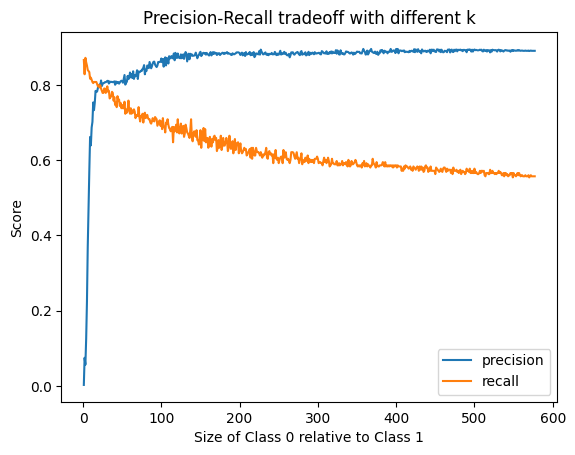

In [57]:
# DO NOT RUN THIS CELL AGAIN
plt.plot(k_value, precisionList, label='precision')
plt.plot(k_value, recallList, label='recall')
plt.ylabel('Score')
plt.xlabel('Size of Class 0 relative to Class 1')
plt.title('Precision-Recall tradeoff with different k')
plt.legend()
plt.show()

In [54]:
# DO NOT RUN THIS CELL AGAIN
def find_nearest(array, value): 
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [55]:
# DO NOT RUN THIS CELL AGAIN
min_idx = find_nearest(diff, 0)
print(f"Best precision-recall tradeoff is when Class 0 is {min_idx} times Class 1.")

Best precision-recall tradeoff is when Class 0 is 19 times Class 1.


## Gaussian Naive Bayes

### Model summary 

\begin{align}
p(y|data) = \frac{p(data|y)*p(y)}{p(data)} \\

p(y|data) \propto p(data|y)*p(y)
\end{align}

Assuming all features $a_1, a_2,..., a_T$ of data are IID: 
\begin{align}
p(data|y) = p(a_1,..., a_T|y) = \prod_{i=1}^T p(a_i|y)
\end{align}

To improve model simplicity, we can eliminate features that have similar distributions between Class 0 and Class 1. In other words, if $p(X_i|y1)$ ~ $p(X_i|y2)$, we can eliminate $X_i$ from the model because: 

\begin{align}
p(y1|data) \propto p(data|y1)*p(y1) = [\prod_{i=1}^T p(x_i|y1)] * p(y1) \\ 

p(y2|data) \propto p(data|y2)*p(y2) = [\prod_{i=1}^T p(x_i|y2)] * p(y2) 
\end{align}
If $p(X_i|y1)$ ~ $p(X_i|y2)$, then the following ratio stays relatively the same. 

\begin{align}
\frac{p(y1|data)}{p(y2|data)} = \frac{[\prod_{i=1}^T p(x_i|y1)] * p(y1)}{[\prod_{i=1}^T p(x_i|y2)] * p(y2)}
\end{align}

Or, the final classificaion is not much influenced by the removal of class $X_i$. 

### Model assumptions

- GNB assumes strong independence between features. However, in real life we don't usually have perfect independence, so we proceed anyways :) This assumption is why the model is named "Naive". 
- GNB assumes the distributions of classes in each feature follows a Gaussian distribution --> this seems like a far reach for out data, because often we don't have normal distribution. But this is the best we can do for now :) 
- From the above formula, we can tell that a heavily imbalanced data set like this will badly influence GNB's prediction as a blind guess of Class 0 will yields accuracy >= 99% (but this is useless for fraud detection purposes) --> need balancing data 
    - Undersampling is preferred because oversampling from 500 observations to 23k observations means 99% fraud observations are synthetic data --> sus 

### GNB on undersampled data

In [56]:
cv4 = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv4.get_n_splits(X_train_raw, y_train_raw)
precision_GNB_und = []
recall_GNB_und = [] 
for i, (train_index, test_index) in enumerate(cv4.split(X_train_raw, y_train_raw)):
    print(f"Fold {i}:")

    ## train_split and test_split will be train and test for the fold i
    ## Both train_split and test_split are raw.
    X_train_fold = X_train_raw.iloc[train_index]
    X_test_fold = X_train_raw.iloc[test_index]
    y_train_fold = y_train_raw.iloc[train_index]
    y_test_fold = y_train_raw.iloc[test_index]

    # undersample the train set 
    tmp = pd.concat([X_train_fold, y_train_fold], axis=1)
    fraud_index = np.array(tmp[tmp.Class==1].index)
    n_fraud = len(fraud_index) 

    genuine_index = np.array(tmp[tmp.Class==0].index)
    rus_genuine_index = np.array(np.random.choice(a=genuine_index, size=n_fraud, replace=False))
    rus_index = np.concatenate([rus_genuine_index, fraud_index])
    undersampled_df = tmp.loc[rus_index]

    if(len(undersampled_df[undersampled_df.Class==0]) == len(undersampled_df[undersampled_df.Class==1])):
        print("Undersampled data is balanced between classes.")

    y_train_fold_und = undersampled_df['Class'].values 
    X_train_fold_und = undersampled_df.drop(['Class'], axis=1)

    # transform & rescale train and test 
    X_train_fold_transform = transformer.fit_transform(X_train_fold_und)
    X_test_fold_transform = transformer.transform(deepcopy(X_test_fold))
    X_train_fold_transform, X_test_fold_transform = \
        robust_scaler(X_train_fold_transform, X_test_fold_transform)
    
    # fit model
    y_und_GNB, y_und_GNB_proba = get_predictions(GaussianNB(),
                                                X_train_fold_transform, y_train_fold_und, X_test_fold_transform)

    print('GAUSSIAN NAIVE BAYES ON UNDERSAMPLED RAW DATA RESULTS')
    fold_precision, fold_recall = print_scores(y_test_fold, y_und_GNB, y_und_GNB_proba)
    precision_GNB_und.append(fold_precision)
    recall_GNB_und.append(fold_recall)

print('------------------------------------')
print("Avg precision score: ", np.array(precision_GNB_und).mean())
print("Avg recall score: ", np.array(recall_GNB_und).mean())

Fold 0:
Undersampled data is balanced between classes.
GAUSSIAN NAIVE BAYES ON UNDERSAMPLED RAW DATA RESULTS
test set confusion matrix:
 [[ 6127 33678]
 [    0    68]]
recall score:  1.0
precision score:  0.002015053635986487
accuracy score:  0.15536829433451207
f1 score:  0.0040220027207665465
ROC AUC: 0.7500158862690913
Fold 1:
Undersampled data is balanced between classes.
GAUSSIAN NAIVE BAYES ON UNDERSAMPLED RAW DATA RESULTS
test set confusion matrix:
 [[ 6584 33220]
 [    0    69]]
recall score:  1.0
precision score:  0.0020727567664994445
accuracy score:  0.1668547638753041
f1 score:  0.004136938665387613
ROC AUC: 0.760413890381711
Fold 2:
Undersampled data is balanced between classes.
GAUSSIAN NAIVE BAYES ON UNDERSAMPLED RAW DATA RESULTS
test set confusion matrix:
 [[ 4805 34999]
 [    0    69]]
recall score:  1.0
precision score:  0.0019676057944564844
accuracy score:  0.12223810598650715
f1 score:  0.003927483848934172
ROC AUC: 0.7205557230429103
Fold 3:
Undersampled data is b

**Comment:** Very high recall, very low precision --> GNB flag almost every transaction as fraud :)

# Final training & testing
From the previous validation result, LogReg on cleaned data and semi-undersampled raw data performs the best. 

We fit Logistic Regression on cleaned data and semi-undersampled raw data, and test the 2 models on X_test_final and y_test_final set. 

## LogReg on cleaned data


In [32]:
# fit model 
y_LR_cleaned_final, y_LR_cleaned_proba_final = \
    get_predictions(LogisticRegression(C=0.01, penalty='l1', solver='liblinear'), 
                    X_train_cleaned_transform, y_train_cleaned, X_test_final)

print('FINAL TEST: LOGISTIC REGRESSION ON CLEANED DATA')
prec_LR_final, rec_LR_final = print_scores(y_test_final, y_LR_cleaned_final, y_LR_cleaned_proba_final)

FINAL TEST: LOGISTIC REGRESSION ON CLEANED DATA
test set confusion matrix:
 [[85266    28]
 [   34   115]]
recall score:  0.7718120805369127
precision score:  0.8041958041958042
accuracy score:  0.9992743700478681
f1 score:  0.7876712328767123
ROC AUC: 0.9671686702905056


## LogReg on semi-undersampled raw data 
Let Class 0 size = 19 times Class 1 size

In [31]:
k = 19 
# undersample the train set 
tmp = pd.concat([X_train_raw, y_train_raw], axis=1)
fraud_index = np.array(tmp[tmp.Class==1].index)
n_fraud = len(fraud_index)

genuine_index = np.array(tmp[tmp.Class==0].index)
### size=k*n_fraud, we tune this k value to find the best
rus_genuine_index = np.array(np.random.choice(a=genuine_index, size=k*n_fraud, replace=False))
rus_index = np.concatenate([rus_genuine_index, fraud_index])
undersampled_df = tmp.loc[rus_index]

y_train_semi = undersampled_df['Class'].values 
X_train_semi = undersampled_df.drop(['Class'], axis=1)

# transform & rescale train and test 
X_train_semi_transform = transformer.fit_transform(X_train_semi)
X_test_fold_transform = transformer.transform(deepcopy(X_test_fold)) # ignore this
X_train_semi_transform, X_test_fold_transform = \
    robust_scaler(X_train_semi_transform, X_test_fold_transform) # only care about X_train_semi_transform

# fit model
y_semi_LR_final, y_semi_LR_proba_final = get_predictions(LogisticRegression(C=0.01, penalty='l1', solver='liblinear'),
                                    X_train_semi_transform, y_train_semi, X_test_final)

print(f'FINAL TEST: LOGISTIC REGRESSION ON SEMI-UNDERSAMPLED RAW DATA')
print(f"Class 0 size is {k} times the size of Class 1")
prec_LRsemi_final, rec_LRsemi_final = print_scores(y_test_final, y_semi_LR_final, y_semi_LR_proba_final)

FINAL TEST: LOGISTIC REGRESSION ON SEMI-UNDERSAMPLED RAW DATA
Class 0 size is 19 times the size of Class 1
test set confusion matrix:
 [[85262    32]
 [   30   119]]
recall score:  0.7986577181208053
precision score:  0.7880794701986755
accuracy score:  0.9992743700478681
f1 score:  0.7933333333333333
ROC AUC: 0.9649422612950422
